In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, ifftshift, fftshift, ifft, fft 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from classicalfield import FiniteTempGPE as gpe

In [2]:
g = gpe(winMult = 2, vortex = False, numImagSteps=500)

No vortices to be spawned
Total Imag Time:  52.14107155799866


In [3]:
num = 100
ksamples = np.zeros((num, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)

for i in range(num): 
    ksamples[i] = g.genPsiK()
 
average_result = np.mean(np.abs(ksamples)**2, axis = 0, dtype = np.complex_)
print(average_result.shape)

(1024, 1024)


In [4]:
coef=g.winL/g.dx**2
psik_sp = coef * (ksamples[0])

psix = ifft2(psik_sp)

In [5]:
def fittingfunc(x, m, b): 
    return m*x+b

def cleandata(grid, noise): 
    mask = (grid > 0) & (noise > 0)

    grid_clean = grid[mask]
    noise_clean = noise[mask]

    return grid_clean, noise_clean

In [6]:
def realpropagate(wf, numSteps): 
    '''
    Note that the psi is now changed to the density so the abs**2 values are eliminated 
    The snapshots are now densities instead of wavefunctions 
    '''
    kinU = np.exp( -(1.0j )*(g.gpeobj.k2)*g.gpeobj.dt)
    
    snapshots = [wf] 
    dynpsi = wf.copy() 

    for i in range(numSteps): 

        potU = np.exp(-(1.0j) *((g.gpeobj.Vbox)+g.gpeobj.g * np.abs(dynpsi)**2-1)*g.gpeobj.dt)

        psiFTold = fft2(wf)
        psiFTnew = psiFTold * kinU 
        psiinterim = ifft2(psiFTnew)
        psinew = potU * psiinterim 
            
        norm = np.sum(np.abs(psinew)**2) * g.dx**g.dim
        dynpsi = np.sqrt(g.gpeobj.Natoms)*psinew/np.sqrt(norm) 
        dynpsiden = g.gpeobj.Natoms/norm * np.abs(psinew)**2
            

        if (i%250 == 0):
            snapshots.append(dynpsi)

    snapshots = np.array(snapshots)


    return snapshots, dynpsi


In [7]:
thermal_wf = psix + g.gs
# norm = np.sum(np.abs(thermal_wf)**2 * g.dx**2)
# #norm = np.sqrt(np.sum(np.abs(thermal_wf)**2 * g.dx**2))
# thermal_wf_norm = thermal_wf/np.sqrt(norm)

# print(np.sum(np.abs(thermal_wf_norm)**2*g.dx**2))
# print(np.sum(np.abs(g.gs)**2 * g.dx**2))

thermal_wf[g.gs<0.1] = 0

norm = np.sum(np.abs(thermal_wf)**2 * g.dx**2)
#norm = np.sqrt(np.sum(np.abs(thermal_wf)**2 * g.dx**2))
thermal_wf_norm = np.sqrt(g.gpeobj.Natoms)*thermal_wf/np.sqrt(norm)




In [8]:
print(np.sum(np.abs(thermal_wf_norm)**2*g.dx**2))

512000.0000000002


In [9]:
def clean(grid, wf): 
    mask = (np.abs(grid[0])<g.L//2)&(np.abs(grid[1])<g.L//2)
    indices = np.argwhere(mask)  
    dim = int(np.sqrt(np.shape(grid[0][mask])))
    grid_clean = np.zeros((2,dim, dim))
    grid_clean[0] = grid[0][mask].reshape((dim, dim))
    grid_clean[1] = grid[1][mask].reshape((dim, dim))
    wf_clean = wf[mask].reshape(dim,dim)
    #grid_clean[0] = np.delete(grid[0], indices, axis = 0) 
    #wf_clean = np.delete(wf, indices, axis = 0)

    return grid_clean, wf_clean 

In [10]:
xgrid_short, wfx_short = clean(g.xi, thermal_wf_norm)

#plt.plot(xgrid_short[0][0], wfx_short[len(wfx_short)//2])


In [11]:
wf_k_norm = fft2(wfx_short)
kgrid_short = g.ki[0][0][0:-2:2]
# print(np.shape(wf_k_norm[0]))

# plt.plot(fftshift(kgrid_short), fftshift(np.abs(wf_k_norm[0])**2))
# plt.yscale('log')
# plt.xscale('log')

In [13]:
# propagate in real time

snaps, psi_f = realpropagate(thermal_wf_norm, 100)

In [14]:
print(np.sum(np.abs(psi_f)**2)*g.dx**2)
print((np.sum(np.abs(snaps[0])**2)*g.dx**2))
print(np.sum(np.abs(thermal_wf_norm)**2)*g.dx**2)

512000.0000000001
512000.0000000001
512000.0000000001


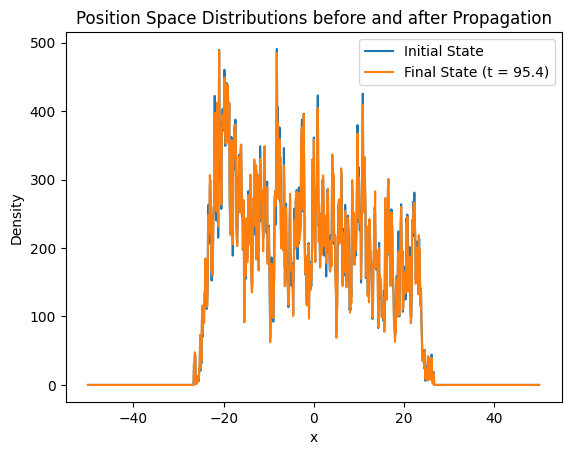

In [15]:
plt.plot(g.xi[0][0], np.abs(snaps[0][len(snaps[0])//2])**2, label = 'Initial State')
plt.plot(g.xi[0][0], np.abs(psi_f[len(psi_f)//2])**2, label = 'Final State (t = 95.4)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Position Space Distributions before and after Propagation')
plt.legend() 
plt.savefig('position_t95.png')

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


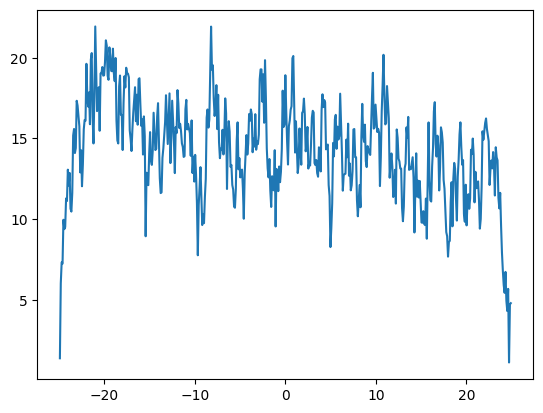

In [18]:
xgrid_shortf, wfx_shortf = clean(g.xi, psi_f)

#plt.plot(xgrid_shortf[0][0], wfx_shortf[len(wfx_shortf)//2])

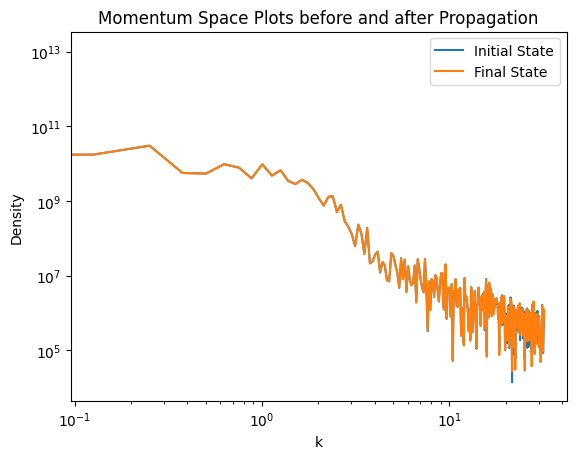

In [17]:
kwf_final = fft2(wfx_shortf)
kgrid_short = g.ki[0][0][0:-2:2]

plt.title('Momentum Space Plots before and after Propagation')
plt.plot(fftshift(kgrid_short), fftshift(np.abs(wf_k_norm[0])**2), label = 'Initial State')
plt.plot(fftshift(kgrid_short), fftshift(np.abs(kwf_final[0])**2), label = 'Final State ')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Density')
plt.legend() 
plt.savefig('momentum_t95.png')

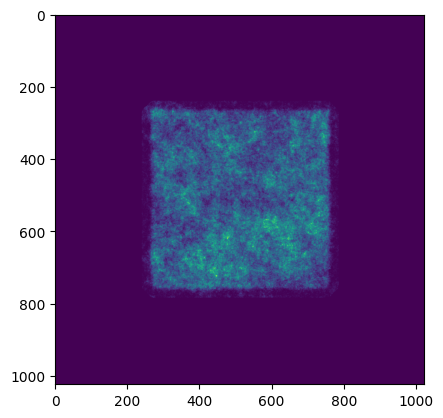

In [21]:
plt.imshow(np.abs(psi_f)**2)

In [22]:
## Take the average 

for i in range(len(ksamples)): 
    snaps_i, psi_fi = realpropagate(thermal_wf_norm, 500)

KeyboardInterrupt: 

TODO:
- Test to make sure there is some 1/k^2 dependence in the thermal noise 
- Propagate for longer times 

In [17]:
def fittingfunc(x, b, m): 
    return b* x**m

def cleandata(grid, noise): 
    mask = (grid > 0) & (noise > 0)

    grid_clean = grid[mask]
    noise_clean = noise[mask]

    return grid_clean, noise_clean

[ 8.52592716e+08 -2.02347529e+00]


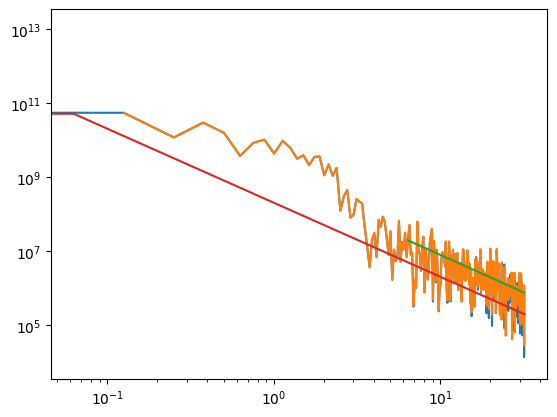

In [30]:
thres = 50
k_clean, noise_clean = cleandata(kgrid_short, np.abs(wf_k_norm[0])**2)
popt, pcov = curve_fit(fittingfunc, k_clean[thres:], noise_clean[thres:])
print(popt)

plt.plot(fftshift(kgrid_short), fftshift(np.abs(kwf_final[0])**2), label = 'Final State')
plt.plot(k_clean, noise_clean)
plt.plot(k_clean[thres:], fittingfunc(k_clean[thres:], *popt))
#plt.plot(ifftshift(g.ki[0][0][1:]), 10e6*ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.yscale('log') 
plt.xscale('log')


Momentum Space Analysis

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


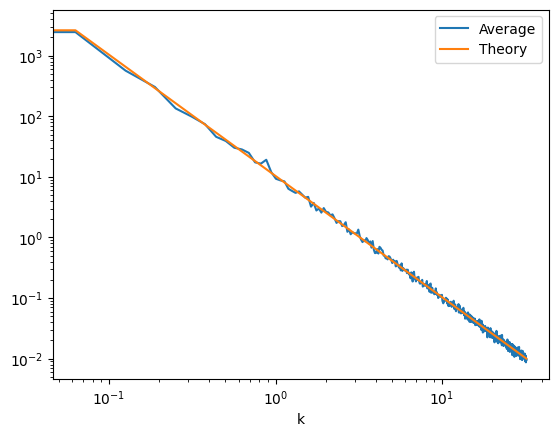

In [18]:
plt.figure() 
# for i in range(num): 
#     plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(ksamples[i][0]**2)))

# exclude the k = 0 mode from this 
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(average_result[0][1:]), label = 'Average')
plt.yscale('log')
plt.xscale('log')
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.xlabel('k')
plt.legend() 

In [ ]:
thermal_wf = psix + g.gs # initial state
# put the thermal part outside of the box equal to 0 

# plane waves inside box 

[-2.55490899 20.50492742]


C:\Users\TQC User\AppData\Local\Temp\ipykernel_26232\4260178040.py:22: RuntimeWarning: invalid value encountered in power
  plt.plot(g.ki[0][0][1:], np.exp(popt[1])*g.ki[0][0][1:]**popt[0], label = 'fitted line')


Text(0.5, 1.0, 'Momentum Space Plots')

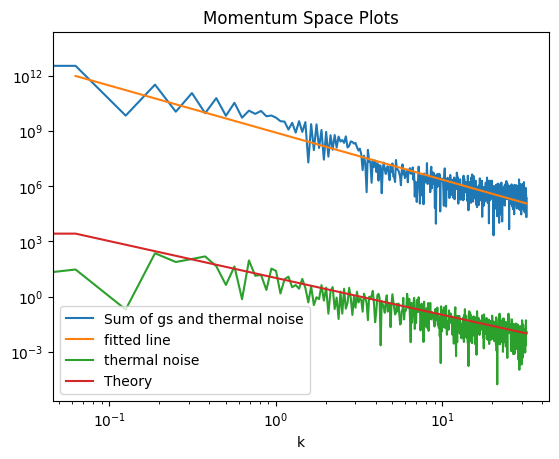

In [17]:
thermal_wf = np.abs(psix)**2 + np.abs(g.gs)**2

norm = np.sum(thermal_wf)*g.dx**2
thermal_wf_norm = g.gpeobj.Natoms* thermal_wf/norm

k_wavf = fft2(np.sqrt(thermal_wf_norm))
curve = np.abs(k_wavf)[0]**2

curve = np.abs(k_wavf)[0]**2

grid = g.ki[0][0] 


clean_grid, clean_curve = cleandata(grid, curve)


popt, pcov = curve_fit(fittingfunc, np.log(clean_grid), np.log(clean_curve))

print(popt)

plt.figure() 
plt.plot(ifftshift(g.ki[0][0]), ifftshift(curve), label = 'Sum of gs and thermal noise') 
plt.plot(g.ki[0][0][1:], np.exp(popt[1])*g.ki[0][0][1:]**popt[0], label = 'fitted line')
plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(ksamples[0])[0]**2), label = 'thermal noise')
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.legend() 
plt.xlabel('k')
plt.yscale('log')
plt.xscale('log')
plt.title('Momentum Space Plots')

In [40]:
print(np.sum(np.abs(psix)**2))
print(np.sum(np.abs(g.gs)**2))

10570485.691144153
53687091.20000001


C:\Users\TQC User\AppData\Local\Temp\ipykernel_26232\2149930127.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(g.ki[0][0], 2*g.T/g.ki[0][0]**2, label = 'Theory')


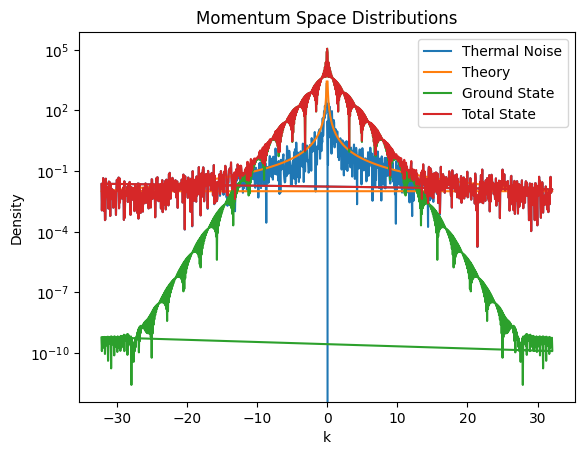

In [33]:
## Momentum Space
plt.figure() 
plt.plot(g.ki[0][0], np.abs(ksamples[0])[0]**2, label = "Thermal Noise")
plt.plot(g.ki[0][0], 2*g.T/g.ki[0][0]**2, label = 'Theory')

plt.plot(g.ki[0][0], np.abs(fft(np.abs(g.gs)[len(g.gs)//2]**2)), label="Ground State")
plt.plot(g.ki[0][0], np.abs(fft(np.abs(g.gs)[len(g.gs)//2]**2)) + np.abs(ksamples[0])[0]**2, label = 'Total State')
#plt.plot(g.ki[0][0], np.abs(xtok)[0]**2, label = "Total State (Transformed from x-space)")
plt.yscale('log')
# plt.xscale('log')
plt.legend() 
plt.title("Momentum Space Distributions")
plt.xlabel('k')
plt.ylabel('Density')
plt.show()

ktox = ifft2(np.sqrt(fft2(np.abs(g.gs)**2) + np.abs(coef*ksamples[0])**2))


Position Space Analysis

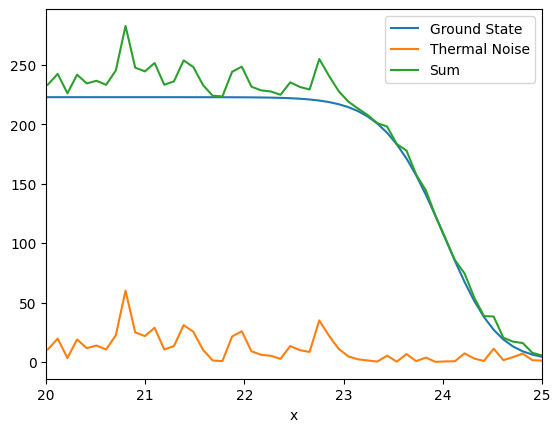

In [37]:
## Position Space 

coef=g.winL/g.dx**2
psik_sp = coef * (ksamples[0])

psix = ifft2(psik_sp)
## ground state 
plt.figure() 
plt.plot(g.xi[0][0], np.abs(g.gs)[len(g.gs)//2]**2, label = 'Ground State')
plt.plot(g.xi[0][0], np.abs(psix)[0]**2, label = 'Thermal Noise')
plt.plot(g.xi[0][0], np.abs(psix)[0]**2 + np.abs(g.gs)[len(g.gs)//2]**2, label = 'Sum')
#plt.plot(g.xi[0][0], fftshift(np.abs(ktox)[0]**2))
plt.xlabel('x')
plt.legend() 
plt.xlim([20,25])
plt.show() 


#xtok = fft2(psix + g.gs)
xtok = fft2(np.sqrt(np.abs(psix)**2 + np.abs(g.gs)**2))

Tasks to do: 
- Try propagating the modified version of the wavefunction 
- Remove the thermal fluctuations outside of the box by setting it equal to zero
- Increase the number of atoms in the thermal cloud by increasing the temperature 
- When plotting - remove the outer window before transforming the box to k space to plot 
    - Compare this to not removing the outer window 

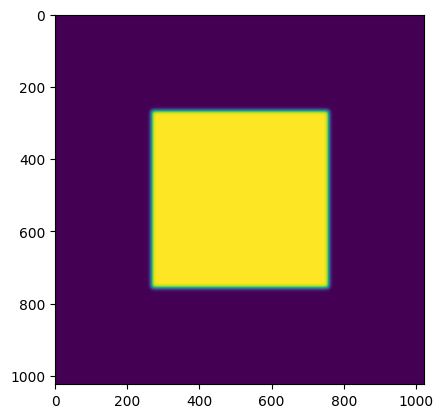

In [41]:
plt.figure() 
plt.imshow(np.abs(g.gs)**2)
plt.show() 